In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def print_line_2points(points):#from line-task 1
    XYarr= points.copy()
    n = len(XYarr)
    
    XYp = {'x':[i[0] for i in XYarr],'y':[i[1] for i in XYarr]}
    sumX = sum(XYp['x'])
    sumY = sum(XYp['y'])
    sumXY = 0.
    sumXqrt = 0.
    
    for i in XYarr:
        sumXY += i[0]*i[1]    
        sumXqrt += i[0]**2
    
    
    if n*sumXqrt - sumX**2 != 0:
        a = (n*sumXY - sumX*sumY)/(n*sumXqrt - sumX**2)
        b = (sumY - a*sumX)/n
        return a,b
    else:
        return 0.,0.

In [49]:
def print_RANSAC(points,t,k):
    model = [0.,0.]
    inline_size = 0.
    for i in range(k):
        model_tmp = [0.,0.]
        inline_size_tmp = 0.
        number_2p=[np.random.randint(1,len(points[0])-1),np.random.randint(1,len(points[0])-1)] 
        print(number_2p)
        two_points = [[points[0][number_2p[0]],points[1][number_2p[0]]],[points[0][number_2p[1]],points[1][number_2p[1]]]]
        a,b = print_line_2points(two_points)
        model_tmp = [a,b]
        
        for j in range(len(points[0])):
            x = points[0][j]
            y = points[1][j]
            
            y1 = a*x+(b-t)
            y2 = a*x+(b+t)
            
            if (y1>y2):
                y1,y2 = y2,y1
            
            if (y1<y and y<y2):
                inline_size_tmp+=1
        
        if (inline_size< inline_size_tmp):
            model = model_tmp
            inline_size = inline_size_tmp
                
        
    a = model[0]
    b = model[1]
    XYl={'x':[min(points[0]),max(points[0])]}
    XYl['y'] = [a*x+b for x in XYl['x']]
    return [[a,b],XYl,inline_size]

In [50]:
def get_noise(MinXY,MaxXY,size_points):
    return [[np.random.uniform(MinXY[0],MaxXY[0]) for i in range(size_points)],[np.random.uniform(MinXY[1],MaxXY[1]) for i in range(size_points)]]

In [51]:
def F(x,par,s=0):
    y = 0.
    for i in range(len(par)):
        y+=par[len(par)-i-1]*(x)**i
    y += s * np.random.randn(len(y))
    return y

In [52]:
def get_points(power=1,count=1,b=None,s=1,noise=False,noise_CountPoints=0,delta_noise=0.,deltaGrafics=1,
               randMIN_b=-10,randMAX_b=10,randMIN_x=-35,randMAX_x=35,randDelta_x=None,step_x=3.9,
               function_CountPoints = None):
    
    if b!=None and (len(b)!=power+1 and power!=1):
        raise Exception("Too few parametrs 'b=[a,b,c,...]'")
    elif power==1:
        power=len(b)-1
    if b==None:
        b = [np.random.uniform(randMIN_b,randMAX_b) for i in range(power+1)]
    
    if randDelta_x==None:
        randDelta_x=(randMAX_x-randMIN_x)/2
    Min_x=np.random.uniform(randMIN_x,randMIN_x+randDelta_x)
    Max_x=np.random.uniform(randMAX_x-randDelta_x,randMAX_x)
        
    if function_CountPoints != None:
        step_x=((Max_x-Min_x)+1)/function_CountPoints
    
    X=np.arange(Min_x,Max_x,step_x) 
    
    Ytmp=[[F(X,(b[:-1]+[b[-1]+(i*(count**3)*b[0]*50*deltaGrafics)]),s)] for i in range(count)]
    Y=[j for i in range(count) for j in Ytmp[i][0].tolist()]
    del Ytmp    
       
    XYp={'x':X.tolist()*count,'y':Y}
    if (noise):
        XYn=get_noise([min(XYp['x'])-delta_noise,min(XYp['y'])-delta_noise],
                      [max(XYp['x'])+delta_noise,max(XYp['y'])+delta_noise],noise_CountPoints)
        XYp['x']+=XYn[0]
        XYp['y']+=XYn[1]
    
    return XYp

In [53]:
def find_function(XYp,t=None,k=None):
    XYp_tmp={'x':XYp['x'].copy(),'y':XYp['y'].copy()}
    inline_size=0.
    inline_size_tmp=0.
    ab=[]
    k=len(XYp['x'])*2
    t_isNot_define=False
    percent_t=0.008
    increasing_t=0.002
    percent=0.75
    increasing_percent=0.02
    
    if t==None:
        t_isNot_define=True
        KOEF_t=max((max(XYp['x'])-min(XYp['x'])),(max(XYp['y'])-min(XYp['y'])))
        print('KOEF=',KOEF_t,' x=',(max(XYp['x'])-min(XYp['x'])),' y=',(max(XYp['y'])-min(XYp['y'])))
    
    while True: 
        inline_size_tmp=0.
        if t_isNot_define:
            t=int(KOEF_t*percent_t)
        else:
            t+=t*percent_t
            
        RANS = print_RANSAC([XYp_tmp['x'],XYp_tmp['y']],t,k)
        #print(RANS[0])
        a=RANS[0][0]
        b=RANS[0][1]
        ab=ab+[[a,b]]
        inline_size_tmp=RANS[2]
        #print(a,'\n',b,'inli = ',inline_size)
        
        if inline_size_tmp>inline_size: 
            tmp_mul=(inline_size_tmp-inline_size)
            if tmp_mul>5 and tmp_mul<=30:
                tmp_mul-=(tmp_mul*0.13)**2
            elif tmp_mul>30:
                tmp_mul=15                
            if inline_size==0:
                tmp_mul=1
                
            percent-=increasing_percent*1.5*tmp_mul
            inline_size=inline_size_tmp
        
        i=0
        while True:
            x = XYp_tmp['x'][i]
            y = XYp_tmp['y'][i]
            
            y1 = a*x+(b-t)
            y2 = a*x+(b+t)
            
            if (y1>y2):
                y1,y2 = y2,y1
            
            if (y1<y and y<y2):
                del XYp_tmp['x'][i]
                del XYp_tmp['y'][i]
                i-=1
                #print('@')
            #print('i=',i,y1,'\t',y,'\t',y2,'\n',len(XYp_tmp['x']))
            i+=1
            if i>=len(XYp_tmp['x'])-1:
                break    
        
        print('_tmp =',inline_size_tmp,'inl =',inline_size,' pr=',percent,' *pr =',inline_size*percent,'t=',t)
        if inline_size_tmp<inline_size*percent:
            del ab[-1]
            break            
        
        
        if percent < 0.9:
            percent+=increasing_percent
            increasing_percent-=increasing_percent*0.2
        if percent > 0.9: 
            percent=0.9
            
        if percent_t < 0.2:
            percent_t+=increasing_t
            increasing_t-=increasing_t*0.2
        if percent_t > 0.2: 
            percent_t=0.2
        print('increasing_t=',increasing_t,' increasing_percent',increasing_percent)
    return ab,k

In [54]:
def print_line_ab(points,ab,k):
    plt.plot(points['x'],points['y'],'ro')

    for i in ab:
        XY=get_points(b=i,randMIN_x=min(points['x']),randMAX_x=max(points['x']),randDelta_x=5)
        Y1=[i-k for i in XY['y']]
        Y2=[i+k for i in XY['y']]
        plt.plot(XY['x'],XY['y'],'b')
        plt.plot(XY['x'],Y1,color='green',linestyle = '--')
        plt.plot(XY['x'],Y2,color='green',linestyle = '--')

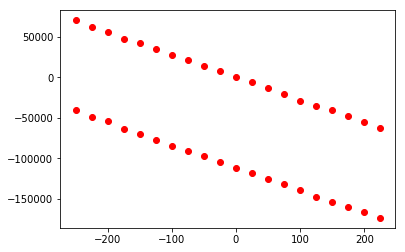

In [55]:
a=-280
b=1
c=3
points=get_points(b=[a,b],s=705,randDelta_x=5,count=2,power=1,randMIN_x=-250,randMAX_x=250,
           function_CountPoints =20,deltaGrafics=1,noise=False,noise_CountPoints=150,delta_noise=550)
plt.plot(points['x'],points['y'],'ro')

In [56]:
k=0
ab,k = find_function(points)

print_line_ab(points,ab,k)

KOEF= 244659.42936514138  x= 474.24538045666907  y= 244659.42936514138
[38, 1]
[3, 26]
[1, 4]
[8, 5]
[36, 37]
[27, 32]
[35, 1]
[20, 28]
[38, 25]
[38, 3]
[26, 36]
[20, 31]
[5, 38]
[14, 35]
[9, 34]
[12, 29]
[28, 22]
[38, 38]
[37, 29]
[12, 20]
[27, 17]
[14, 2]
[16, 28]
[38, 35]
[22, 11]
[22, 24]
[25, 5]
[3, 14]
[27, 17]
[18, 30]
[32, 35]
[29, 35]
[33, 5]
[4, 25]
[17, 2]
[16, 31]
[21, 14]
[13, 26]
[27, 5]
[35, 3]
[36, 35]
[23, 18]
[16, 13]
[9, 20]
[32, 30]
[12, 32]
[13, 29]
[28, 17]
[37, 6]
[33, 13]
[11, 38]
[2, 28]
[12, 17]
[6, 31]
[32, 6]
[26, 23]
[12, 28]
[13, 14]
[26, 37]
[17, 18]
[9, 17]
[25, 31]
[32, 29]
[22, 25]
[1, 29]
[24, 32]
[6, 14]
[6, 13]
[8, 25]
[6, 11]
[15, 38]
[36, 9]
[31, 28]
[22, 1]
[1, 3]
[4, 36]
[12, 36]
[7, 11]
[34, 35]
[17, 5]
_tmp = 20.0 inl = 20.0  pr= 0.72  *pr = 14.399999999999999 t= 1957
increasing_t= 0.0016  increasing_percent 0.016
[4, 6]
[11, 5]
[6, 4]
[10, 3]
[8, 3]
[18, 9]
[5, 18]
[13, 1]
[10, 10]
[18, 3]
[4, 7]
[4, 18]
[11, 5]
[9, 17]
[1, 10]
[13, 5]
[5, 1]

ValueError: Range cannot be empty (low >= high) unless no samples are taken